# Time series prediction (Part 2 - 1.5 day)

**NB objectives**
- [ ] Get to use few prediction models
- [ ] Understand what CV is for

**Required librairies**
- [ ] matplotlib
- [ ] numpy
- [ ] pandas
- [ ] seaborn
- [ ] pmdarima

## SARIMA: Dealing now with seasonality

As previously seen, ARIMA model is for stationary data. It may even works for data presenting seasonality. However, seasonality is not clearly expressed. If data shows seasonality less simple as for the airport's data, calculation complexity and time can explode. E.g. data compiling sun activity with a seasonality of 12 +/-1 year would require a minimum of *p = 12 year x 12 months* to comprehend seasonality of the problem.

One way could be to deal with the tendency and the seasonality with one model coupled with another one that deals with the variability inside the seasonality. **Here comes SARIMA: Seasonal-ARIMA!**

To start, define what are the parameter of the SARIMA model. The parameters are written (p, d, Q), (P, D, Q)m.
1. Read the documentation from the page 15: [click here](https://people.duke.edu/~rnau/Slides_on_ARIMA_models--Robert_Nau.pdf)
1. What are the P,D, Q and m?
2. What are the p,d and q?
3. What could mean *(1, 0, 1) (1, 1, 2)12*?

# `answer here`
P, D, Q, are seasonal autoregressive, differences, moving-average terms correspondingly

p,d, q is the same as for arima

m is a period (for 12 it is monthly, 4 - quartally, 7 - daily, 1 - for no seasonality)

(1, 0, 1) (1, 1, 2)12 means number of autoregressive terms is 1 (as well as for seasonality), differences terms are 0 and 1 for seasonality, moving-average is 1 for no-seasonal and 2 for seasonality, 12 stands for m, meaing at has a monthly period

### Manage data for SARIMA

In [1]:
from pandas import date_range
from pmdarima.datasets import load_airpassengers

In [2]:
START_DATE = "1949-01-01"
airline = load_airpassengers(as_series=True)

# there's no datetimeindex from the bundled dataset. So let's add one.
airline.index = date_range(START_DATE, periods=len(airline), freq="MS")

In [3]:
# train / test split here


def ts_train_test_split(data, split_date):
    """
    Split time series into training and test data

    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series

    Returns:
    --------
    tuple (len=2)
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    """
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]
    return train, test

# hold back the last twelve months as a TEST set
train, test = ts_train_test_split(airline / airline.index.days_in_month, "1959-01-01")

In [5]:
train.shape, test.shape

((120,), (24,))

### Evaluate the parameters of the S-ARIMA

We already know that the airline serie is seasonal, and we know that it is a yearly one. But let's respect the methodology.

1. Remember, as view in the first notebook of the module, we need to determine the seasonality before building a S-ARIMA model.
    - you can use visual tools such as `decompose` or `decomposed_plot` from `pmdarima`
    - you can use ACF or PACF plots.
    - or you can use statistic tests.
2. Once you know the seasonality, we should work on the integration to establish all the parameter of the S-ARIMA models from ACF and PACF plots.

#### Determine the seasonality from visualization

To get the seasonality you can use the function `decompose` and `decomposed_plot` from `pmdarima`. Plot with different lag and observe the results. When you get a periodic signal for seasonality without seasonality for trend and random (=residue), you can conclude you have a seasonal signal and its length of seasonality.

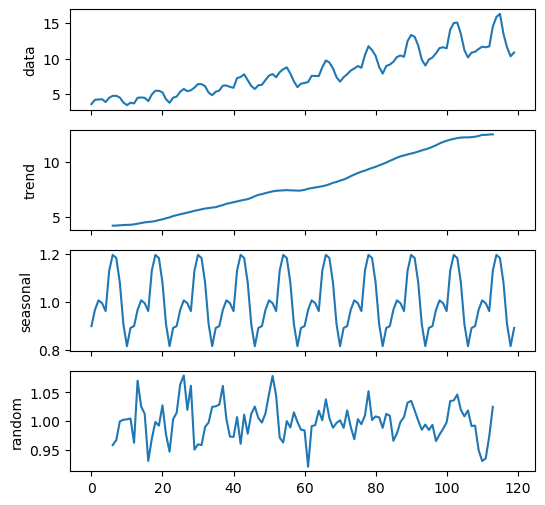

In [13]:
# your code to get the seasonality with plots.

# additive because the original signal is multiplicative, but we are in log.
from pmdarima import decompose
from pmdarima.utils import decomposed_plot
import matplotlib.pyplot as plt

decomposed = decompose(train.values, "multiplicative", m=12)
decomposed_plot(decomposed, figure_kwargs={"figsize": (6, 6)}, show=False)
plt.show()

# What is the seasonality?  
`reply here`

it is a monthly data with year seasonality (trend has no seasonal featues for m=12)

You can also use the PACF and ACF plots. The "bridge" shape on ACF and high correlation every `n` lag means oftentimes that the signal is seasonal.

In [17]:
from pmdarima.utils import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

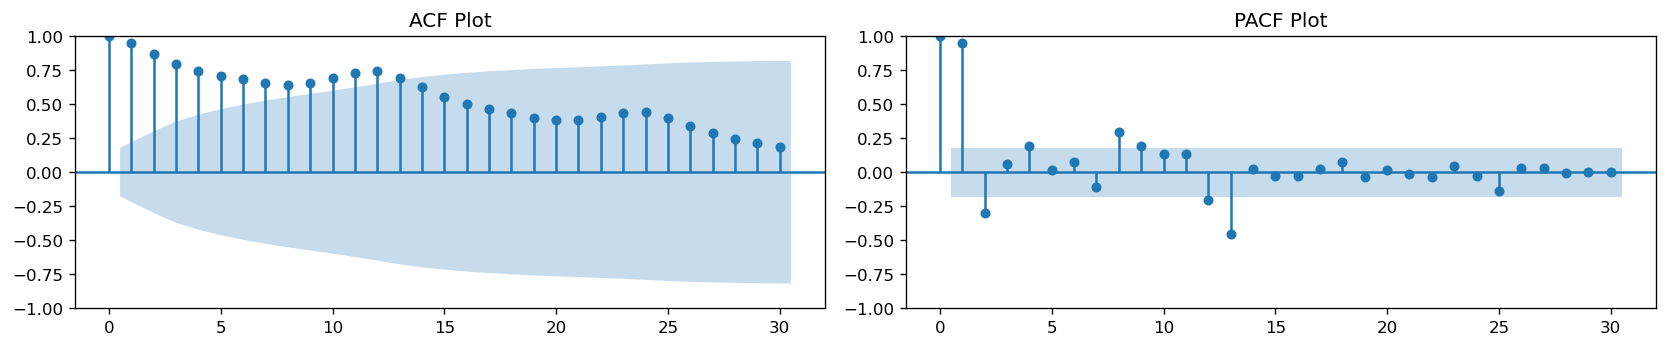

In [58]:
# your code with ACF and PACF on the raw signal.
plt.figure(figsize=(14,3))

plt.subplot(121)
plot_acf(train.dropna(), lags=30, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(train.dropna(), lags=30, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

### Periodic spikes for ACF => seasonality = 12 (spikes at 12, 24 etc) for PACF it is also a spike at 12

#### Evaluate the seasonality from statistics

Until this moment, we use some visual tool to evaluate the stationarity. But statistical tools exist.
1. Look at the documentation about `nsdiffs`: [click here](https://alkaline-ml.com/pmdarima/tips_and_tricks.html#estimating-the-seasonal-differencing-term-d)
2. Write the code to evaluate the stationary and the integration `D`.

In [61]:
# code here
from pmdarima.arima.utils import nsdiffs

D_ocsb = nsdiffs(train,
            m=12,  # commonly requires knowledge of dataset
            max_D=24,
            test='ocsb')  # -> 0
D_ch = nsdiffs(train,
            m=12,  # commonly requires knowledge of dataset
            max_D=12,
            test='ch')  # -> 0
print(D_ocsb, D_ch)

1 0


### Evaluate the parameters of SARIMA (OPTIONAL - Pass below, if you struggle on this part)

#### Determine the integration parameters

We have strong assumptions about the length of the seasonality $m$. Now, we can evaluate the values of the $(p, d, q)(P, D, Q)_m$ parameters.

To do so, try to get a stationnary signal with the data by integrate the signal at the first or second level, or both:
1. the seasonal level (to get the *D*), if there is a strong seasonal component.
2. and the inter-seasonal level (to get the *d*) if there is a trend.

What are the integration to get a stationnary signal? Reply below your code.

Attention: Do not use `log` this time.

In [33]:
# see two function that can help you to evaluate the rolling mean and variance, so evaluate the stationnarity with plots.
import numpy as np

def rolling_mean(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n

def rolling_std(a, n=3):
    j = len(a) - n
    mov_std = np.array([np.std(a[k : k + n]) for k in range(j)])
    return mov_std

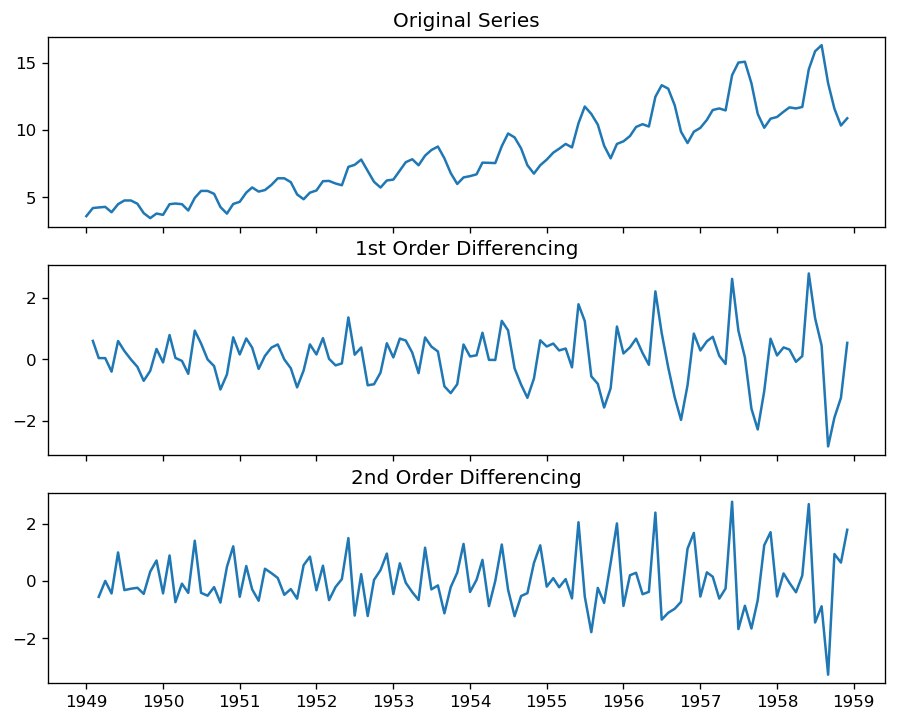

In [41]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(train); axes[0].set_title('Original Series')

axes[1].plot(train.diff()); axes[1].set_title('1st Order Differencing')

axes[2].plot(train.diff().diff()); axes[2].set_title('2nd Order Differencing')
plt.show()

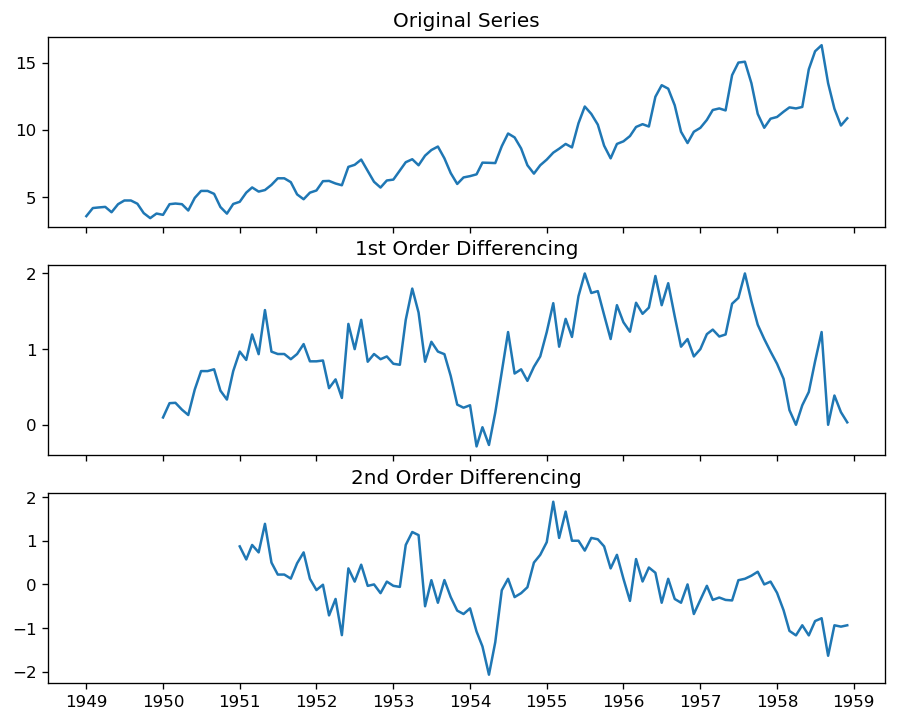

In [42]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(train); axes[0].set_title('Original Series')

axes[1].plot(train.diff(12).dropna()); axes[1].set_title('1st Order Differencing')

axes[2].plot(train.diff(12).dropna().diff(12).dropna()); axes[2].set_title('2nd Order Differencing')
plt.show()

In [63]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    if result[1] <= 0.05:
        print("=> The series is stationary.")
    else:
        print("=> The series is non-stationary.")

adf_test(train.diff(12).dropna(), title='Values')

Augmented Dickey-Fuller Test: Values
ADF Statistic: -2.7235080869084936
p-value: 0.07005793345176618
# Lags Used: 1
# Observations: 106
=> The series is non-stationary.


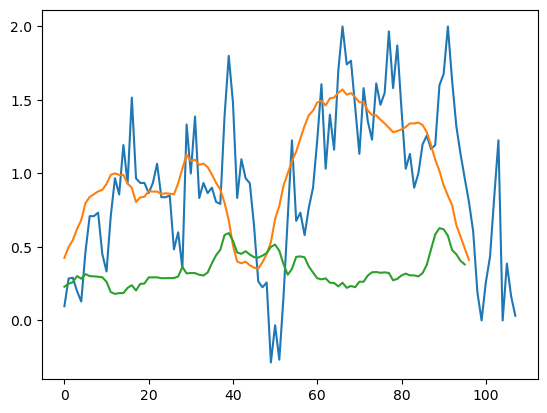

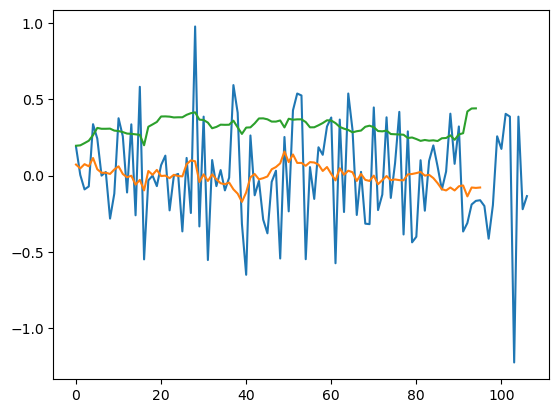

In [34]:
# your code here to get a stationnary signal from the time series by one integration on interseasonal scale, seasonal one or both.
# Use the plots to validate your transformation.

x = train.values # d = 0
x = x[12:] - x[:-12]  # D = 1

plt.plot(x)
plt.plot(rolling_mean(x, 12)) 
plt.plot(rolling_std(x, 12))
plt.show()

x = np.diff(train.values) # d = 1
x = x[12:] - x[:-12] # D = 1

plt.plot(x)
plt.plot(rolling_mean(x, 12))
plt.plot(rolling_std(x, 12))
plt.show()

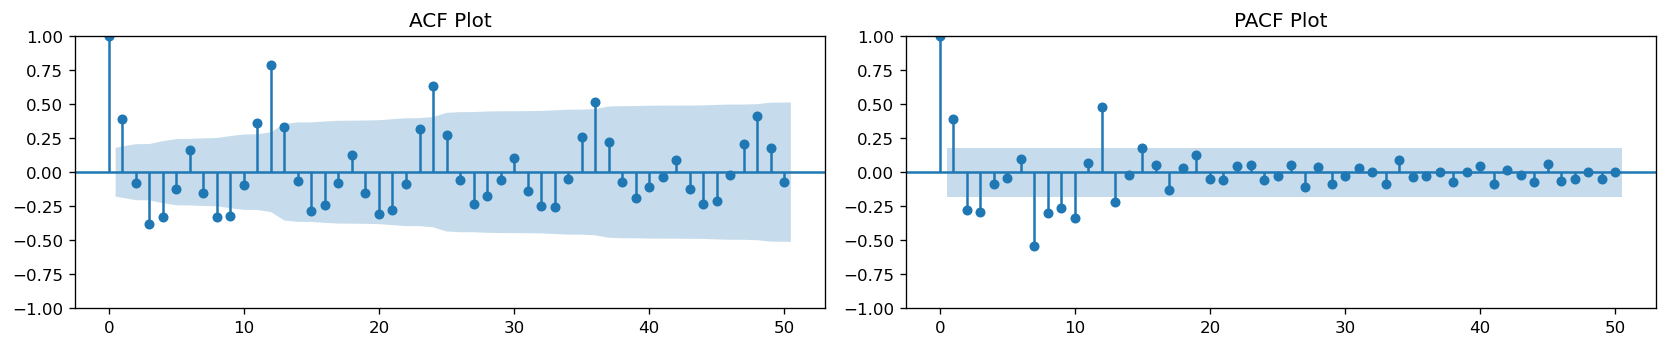

In [73]:
plt.figure(figsize=(14,3))

plt.subplot(121)
plot_acf(train.diff().dropna(), lags=50, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(train.diff().dropna(), lags=50, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

### from ACF: q = 1 (1 lag peak) + same for p

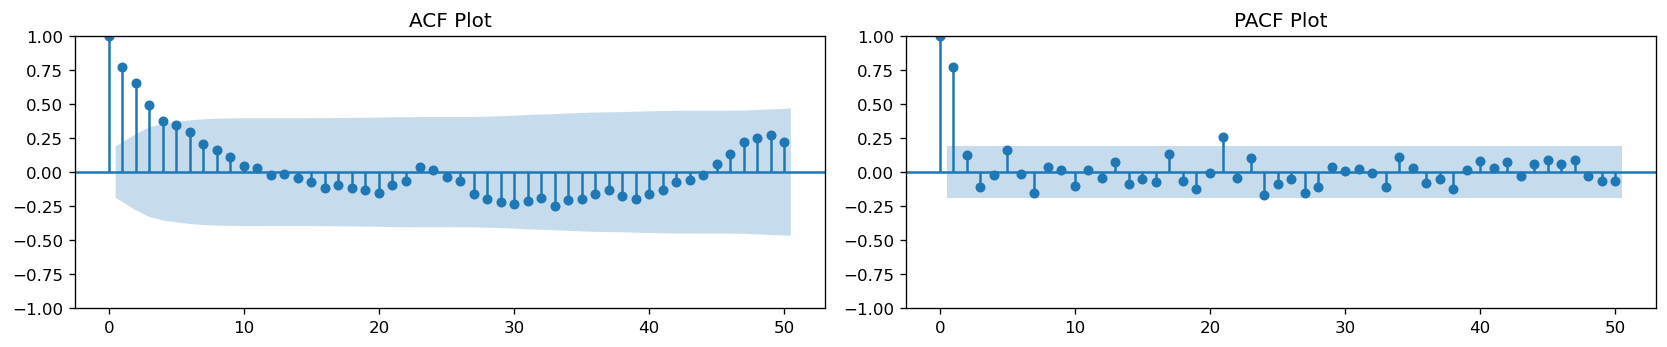

In [72]:
plt.figure(figsize=(14,3))

plt.subplot(121)
plot_acf(train.diff(12).dropna(), lags=50, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(train.diff(12).dropna(), lags=50, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

### No peaks at 12, 24 => Q = 0 amd same for P

# What are the values of the integration paramters $d$ and $D$?  
`reply here`
it is not super clear for d (1 looks good for the first half and 2 for the second, but i would stick to 1)

for D is better : 1 is enough

#### Determine the correlation parameters

- With ACF and PACF plots, determine all the other parameters. (Read the first documentation provided above).

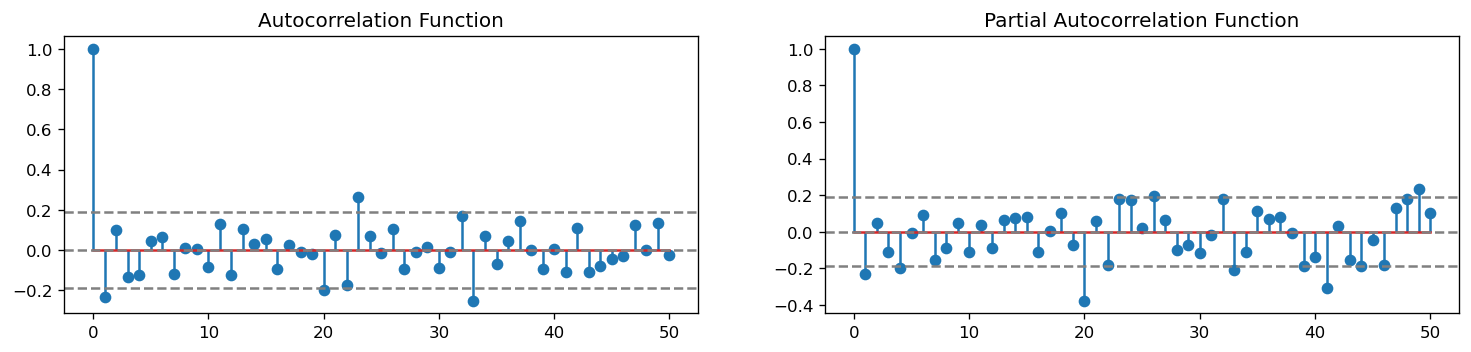

In [74]:
# ACF & PACF plots
from pmdarima.utils import acf, pacf
import numpy as np

x = np.diff(train.values)  # d = 1
x = x[12:] - x[:-12]

n_sample = len(x)
lag_acf = acf(x, nlags=50)
lag_pacf = pacf(x, nlags=50)

pct_95 = 1.96 / np.sqrt(n_sample)

plt.figure(figsize=(15, 3))
# Plot ACF:
plt.subplot(121)
plt.stem(lag_acf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-pct_95, linestyle="--", color="gray")
plt.axhline(y=pct_95, linestyle="--", color="gray")
# plt.axvline(x=q, color='black', linestyle='--', label=f'q={q}')
# plt.legend()
plt.title("Autocorrelation Function")

# Plot PACF
plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(
    y=-pct_95, linestyle="--", color="gray"
)  # represente 95 % des données d'une gaussienne
plt.axhline(
    y=pct_95, linestyle="--", color="gray"
)  # represente 95 % des données d'une gaussienne
# plt.axvline(x=p, color='black', linestyle='--', label=f'p={p}')
plt.title("Partial Autocorrelation Function")
# plt.legend()
plt.show()

In case, the answer is $(0, 1, 1)(0, 1, 1)_{12}$.  
Is it coherent with your plots?  
How do you justify these numbers?

`reply here`

## Build your model

1. build the SARIMA model with ARIMA class from `pmdarima`: [click here](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html)
2. Train and evaluate your model. Select a metric for TS. [Click here](https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27)
3. Is it better than the classical ARIMA model without seasonal order?

In [76]:
# your code here
from pmdarima.arima import ARIMA
p, d, q = 0, 1, 1
model_1 = ARIMA((p,d,q), seasonal_order=(0,1,1,12))

In [77]:
model_1_fit = model_1.fit(train)
print(model_1_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -30.939
Date:                            Thu, 10 Oct 2024   AIC                             69.879
Time:                                    12:28:31   BIC                             80.570
Sample:                                01-01-1949   HQIC                            74.213
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0006      0.025     -0.022      0.982      -0.049       0.048
ma.L1         -0.2065      0.092   

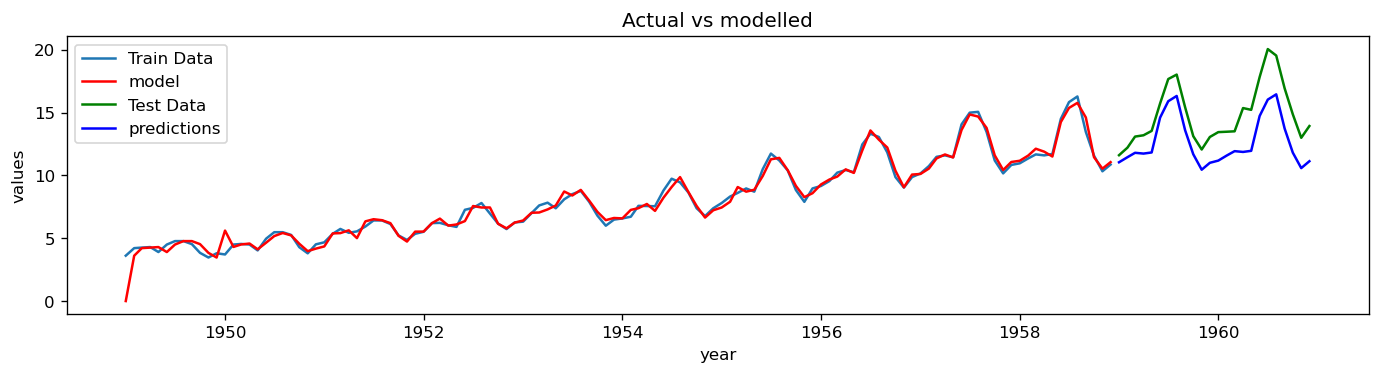

In [78]:
plt.figure(figsize=(14,3))
plt.plot(train.index, train, label='Train Data')
plt.plot(model_1_fit.fittedvalues().index, model_1_fit.fittedvalues(), label='model', color='red')
plt.plot(test.index, test, label='Test Data', color='green')
plt.plot(model_1.predict(24).index, model_1.predict(24), label = 'predictions', color='blue')
plt.legend()
plt.title('Actual vs modelled')
plt.xlabel('year')
plt.ylabel('values')
plt.show()

In [79]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, model_1.predict(24))
mse = mean_squared_error(test, model_1.predict(24))
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - model_1.predict(24)) / test)) * 100

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")

Mean Absolute Error (MAE): 2.146
Mean Squared Error (MSE): 5.410
Root Mean Squared Error (RMSE): 2.326
Mean Absolute Percentage Error (MAPE): 14.219%


`your observations and conclusion here`

## Optional: Redo the work but on another dataset

1. Select another dataset:
- from `pmdarima` between: `['airpassengers', 'ausbeer', 'austres', 'gasoline', 'heartrate', 'lynx', 'msft', 'sunspots', 'taylor', 'wineind', 'woolyrnq']`
- or from https://data.world/datasets/time-series 

2. realize the same work as above.

In [103]:
import pmdarima

dataset_names = ['airpassengers', 'ausbeer', 'austres', 
                 'gasoline', 'heartrate', 'lynx', 'sunspots', 
                 'taylor', 'wineind', 'woolyrnq']
def get_ds(ds_name, red_factor=None):
    '''
    Loads a dataset of pmdarima from its ds_name.
    '''
    ds = getattr(pmdarima.datasets, 'load_'+ds_name)(as_series=True).dropna()
    if red_factor is not None:
        assert isinstance(red_factor, int)
        ds= ds.groupby(np.arange(ds.index.shape[0])//red_factor).mean()
    START_DATE = "1949-01-01"
    ds.index = date_range(START_DATE, periods=len(ds), freq="MS")
    return ds

In [104]:
ausbeer = get_ds(dataset_names[1])
ausbeer.shape

(211,)

In [107]:
int(len(ausbeer)*0.8)

168

In [90]:
from pmdarima import auto_arima

In [125]:
def autoarima_with_plot_and_stats(data, data_name, seasonal_period=12):
    
    test_size = int(len(data)*0.2)
    
    train = data[:-test_size]
    test = data[-test_size:]
    
    model = auto_arima(train,
                       start_p=0,
                       start_q=0,
                       start_P=0,
                       start_Q=0,
                       seasonal=True, 
                       m=seasonal_period, 
                       trace=True, 
                       error_action='ignore',
                       stepwise=True,
                       suppress_warnings=True)
    
    model_fit = model.fit(train)
    
    predictions = model.predict(n_periods=test_size)
    
    plt.figure(figsize=(14, 3))
    plt.plot(train.index, train, label='Train Data', color='black')
    plt.plot(test.index, test, label='Test Data', color='green')
    plt.plot(train.index, model_fit.fittedvalues(), label='Model Fit', color='red')
    plt.plot(test.index, predictions, label='Predictions', color='blue')
    
    plt.legend()
    plt.title(f'Actual vs Modeled: {data_name}')
    plt.xlabel('Year')
    plt.ylabel('Values')
    plt.show()
    
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test - predictions) / test)) * 100
    
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")
    
    return model_fit

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1496.441, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1381.391, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1365.951, Time=0.49 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1405.619, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1367.863, Time=0.70 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1367.866, Time=1.11 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1378.164, Time=0.38 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1369.888, Time=2.27 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1450.206, Time=0.21 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1351.023, Time=0.63 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1388.080, Time=0.13 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1352.980, Time=0.83 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1352.975, Time=1.16 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1362.795, Time=0.40 sec
 ARIMA(1,1,1)(1,1,2

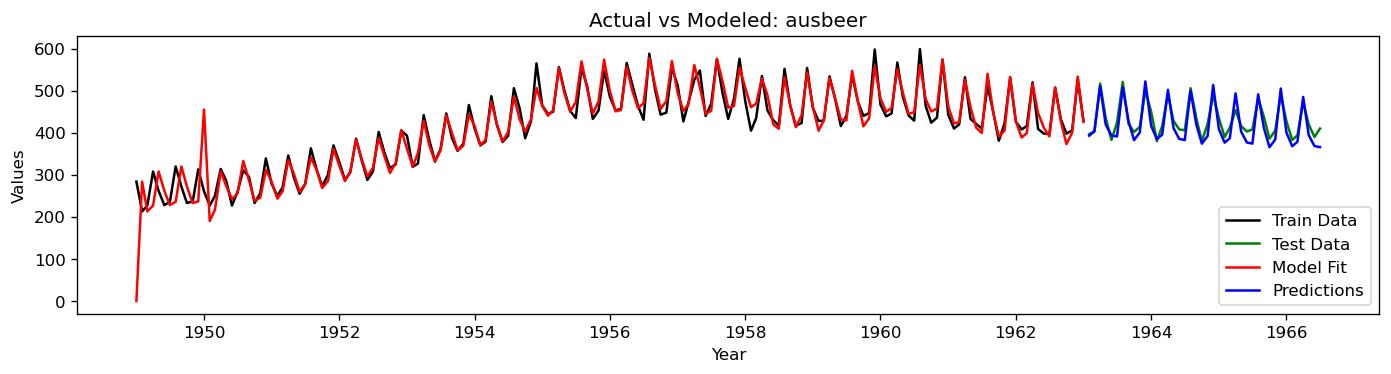

Mean Absolute Error (MAE): 18.738
Mean Squared Error (MSE): 447.686
Root Mean Squared Error (RMSE): 21.159
Mean Absolute Percentage Error (MAPE): 4.401%


ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [126]:
autoarima_with_plot_and_stats(ausbeer,'ausbeer',12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=765.723, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=764.756, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=765.328, Time=0.33 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=764.138, Time=0.07 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=764.944, Time=0.21 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=766.619, Time=0.42 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=765.206, Time=0.09 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=762.550, Time=0.18 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=765.329, Time=0.38 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=765.510, Time=0.51 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=767.126, Time=0.86 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=764.631, Time=0.07 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=766.465, Time=0.17 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=766.346, Time=0.18 sec
 ARIMA(0,1,2)(0,1,0)[12]         

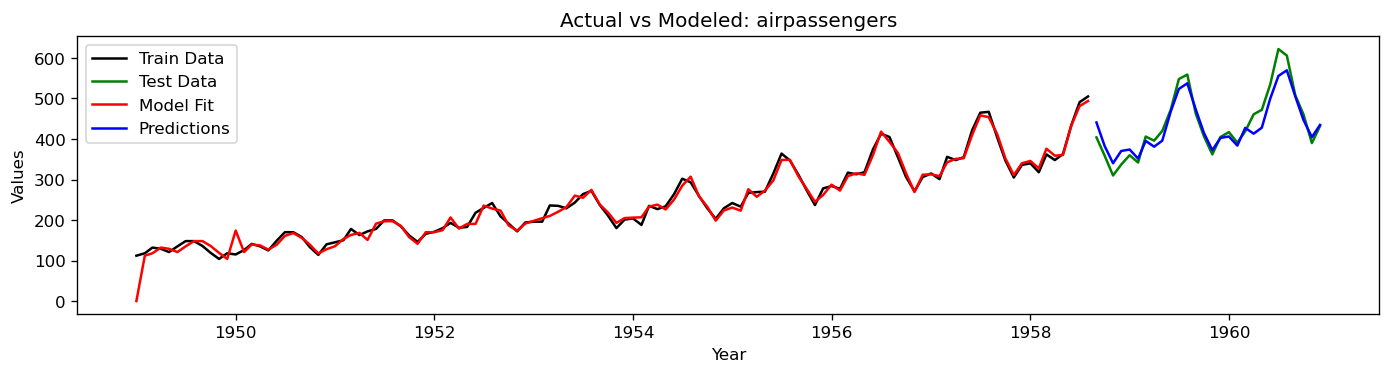

Mean Absolute Error (MAE): 20.317
Mean Squared Error (MSE): 655.791
Root Mean Squared Error (RMSE): 25.608
Mean Absolute Percentage Error (MAPE): 4.586%


ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [127]:
autoarima_with_plot_and_stats(get_ds(dataset_names[0]),dataset_names[0],12)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=504.649, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=486.586, Time=0.21 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=486.911, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=496.743, Time=0.04 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=487.968, Time=0.26 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=487.772, Time=0.23 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=489.232, Time=0.11 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=inf, Time=1.74 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=498.265, Time=0.09 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=487.047, Time=0.14 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=486.845, Time=0.21 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=485.438, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=492.406, Time=0.04 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=487.143, Time=0.24 sec
 ARIMA(0,2,1)(1,0,1)[12]             

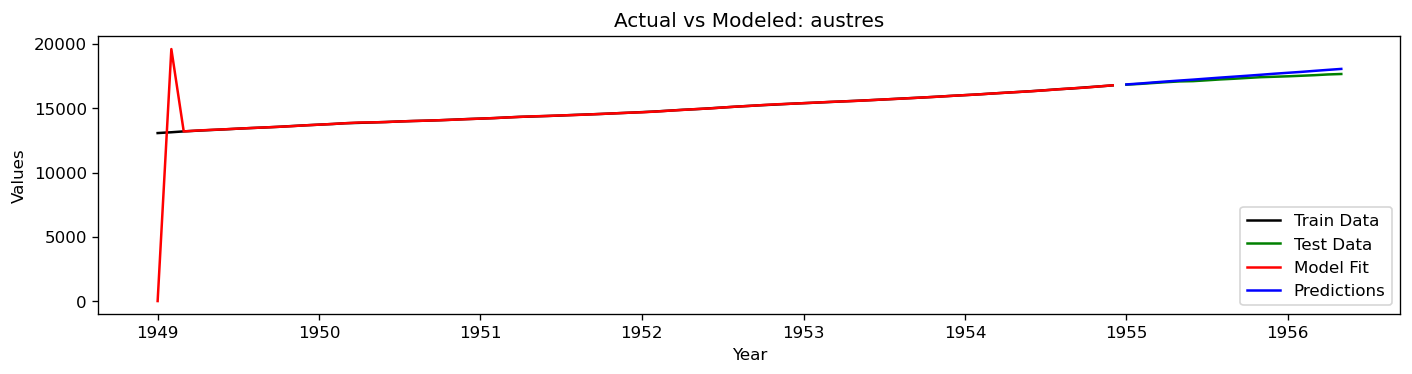

Mean Absolute Error (MAE): 177.287
Mean Squared Error (MSE): 45180.969
Root Mean Squared Error (RMSE): 212.558
Mean Absolute Percentage Error (MAPE): 1.017%


ARIMA(order=(3, 2, 2), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [128]:
autoarima_with_plot_and_stats(get_ds(dataset_names[2]),dataset_names[2],12)

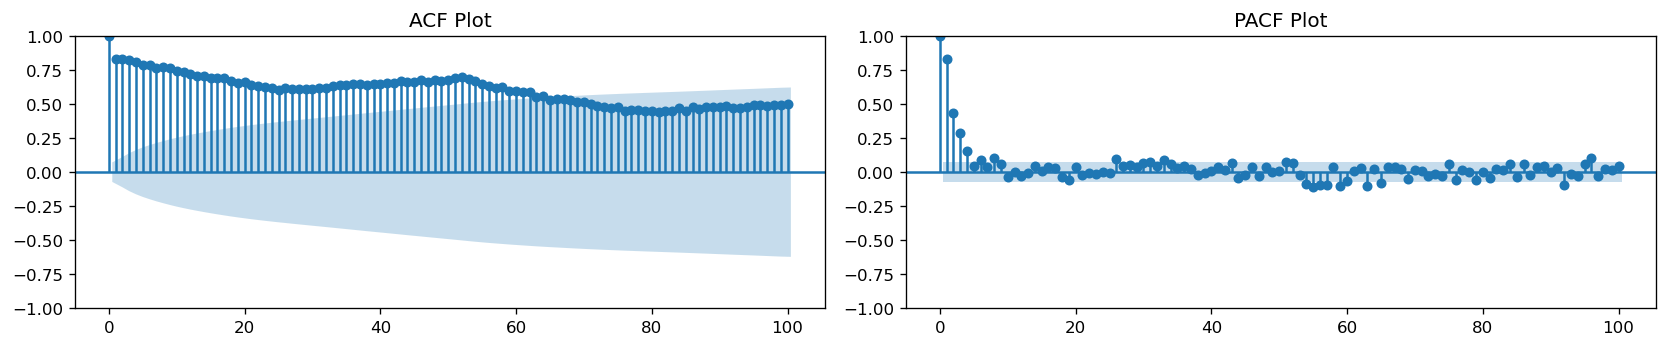

In [139]:
plt.figure(figsize=(14,3))

plt.subplot(121)
plot_acf(get_ds(dataset_names[3]).dropna(), lags=100, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(get_ds(dataset_names[3]).dropna(), lags=100, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

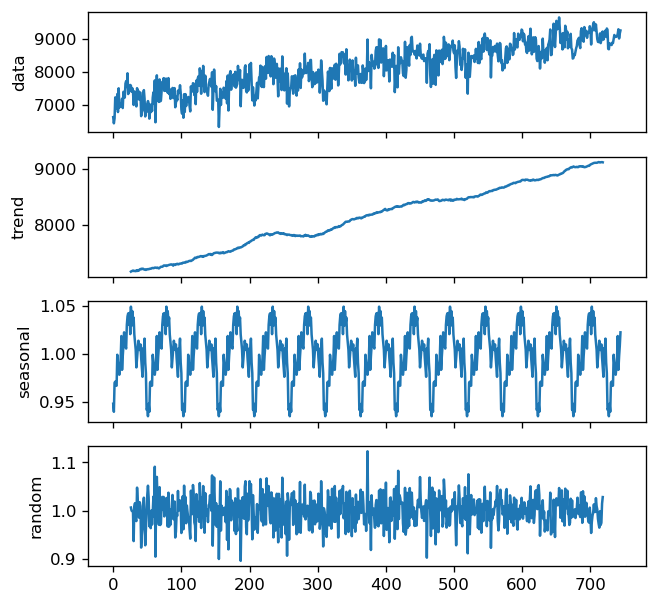

In [141]:
decomposed = decompose(get_ds(dataset_names[3]).values, "multiplicative", m=52)
decomposed_plot(decomposed, figure_kwargs={"figsize": (6, 6)}, show=False);

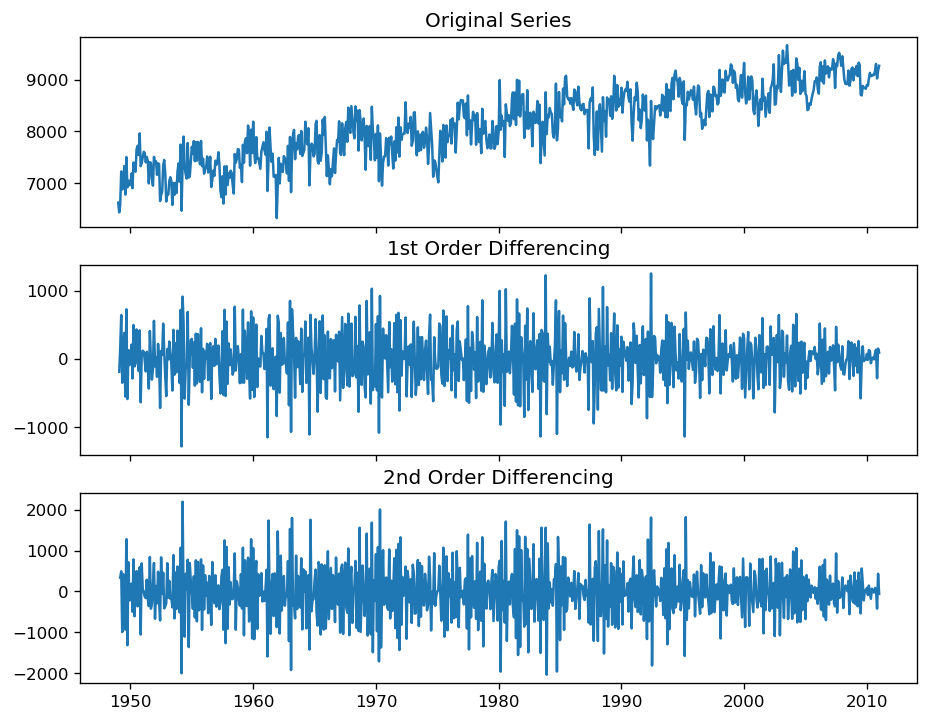

In [147]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(get_ds(dataset_names[3])); axes[0].set_title('Original Series')

axes[1].plot(get_ds(dataset_names[3]).diff()); axes[1].set_title('1st Order Differencing')

axes[2].plot(get_ds(dataset_names[3]).diff().diff()); axes[2].set_title('2nd Order Differencing')
plt.show()

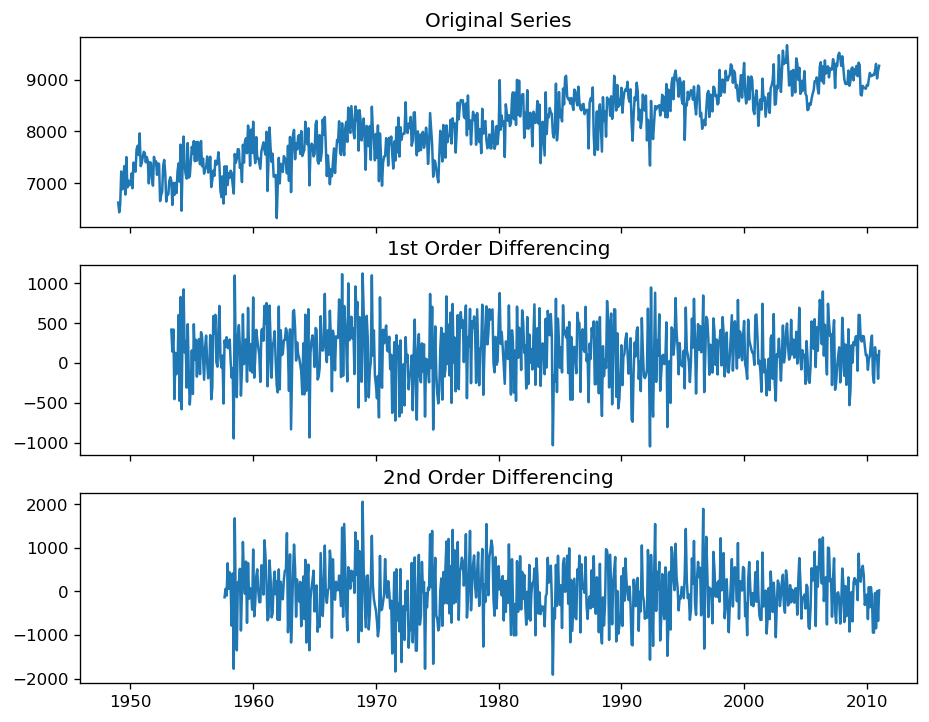

In [148]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(get_ds(dataset_names[3])); axes[0].set_title('Original Series')

axes[1].plot(get_ds(dataset_names[3]).diff(52)); axes[1].set_title('1st Order Differencing')

axes[2].plot(get_ds(dataset_names[3]).diff(52).diff(52)); axes[2].set_title('2nd Order Differencing')
plt.show()

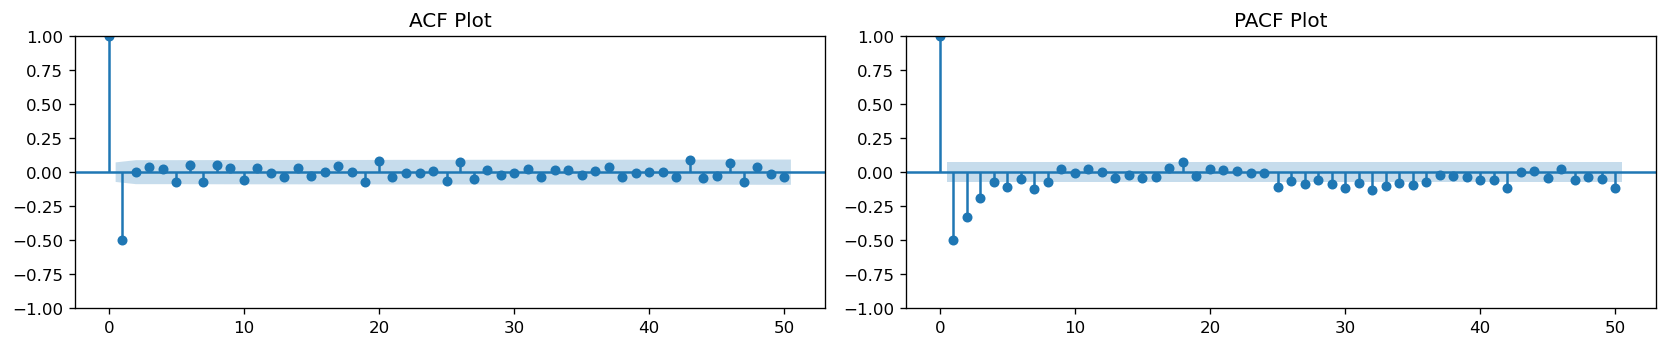

In [151]:
plt.figure(figsize=(14,3))

plt.subplot(121)
plot_acf(get_ds(dataset_names[3]).diff().dropna(), lags=50, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(get_ds(dataset_names[3]).diff().dropna(), lags=50, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

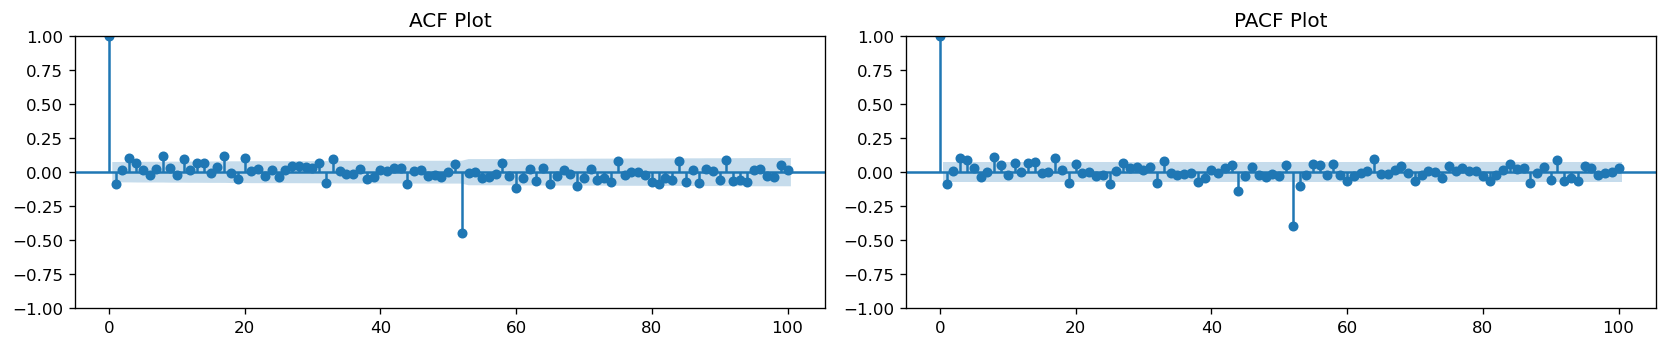

In [153]:
plt.figure(figsize=(14,3))

plt.subplot(121)
plot_acf(get_ds(dataset_names[3]).diff(52).dropna(), lags=100, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(get_ds(dataset_names[3]).diff(52).dropna(), lags=100, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

In [154]:
p, d, q = 3, 1, 1
P, D, Q = 1, 1, 1
m = 52

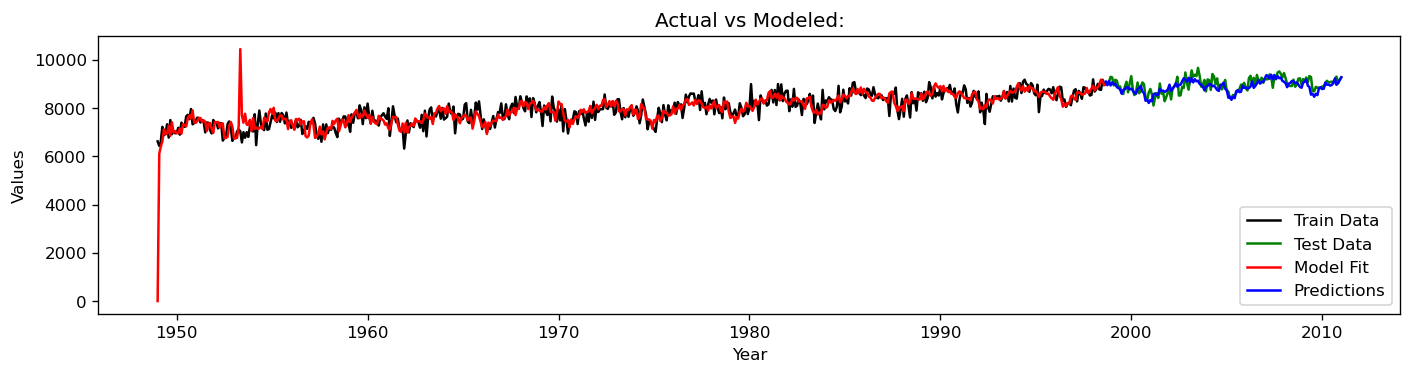

Mean Absolute Error (MAE): 189.174
Mean Squared Error (MSE): 57061.143
Root Mean Squared Error (RMSE): 238.875
Mean Absolute Percentage Error (MAPE): 2.100%


In [156]:
model = ARIMA((p,d,q), seasonal_order=(P,D,Q,m))

data = get_ds(dataset_names[3])

test_size = int(len(data)*0.2)

train = data[:-test_size]
test = data[-test_size:]

model_fit = model.fit(train)

predictions = model.predict(n_periods=test_size)

plt.figure(figsize=(14, 3))
plt.plot(train.index, train, label='Train Data', color='black')
plt.plot(test.index, test, label='Test Data', color='green')
plt.plot(train.index, model_fit.fittedvalues(), label='Model Fit', color='red')
plt.plot(test.index, predictions, label='Predictions', color='blue')

plt.legend()
plt.title(f'Actual vs Modeled:')
plt.xlabel('Year')
plt.ylabel('Values')
plt.show()

mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - predictions) / test)) * 100

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")

In [279]:
def get_ds(ds_name, red_factor=None):
    '''
    Loads a dataset of pmdarima from its ds_name.
    '''
    ds = getattr(pmdarima.datasets, 'load_'+ds_name)(as_series=True).dropna()
    if red_factor is not None:
        assert isinstance(red_factor, int)
        ds= ds.groupby(np.arange(ds.index.shape[0])//red_factor).mean()
    return ds

In [282]:
import pandas as pd

In [286]:
heart_rate = pd.DataFrame(get_ds(dataset_names[4]))

In [295]:
index = np.arange(0,75,0.5)
index.shape

(150,)

In [298]:
heart_rate.index = index

In [297]:
heart_rate.head()

,0
0.0,84.2697
0.5,84.2697
1.0,84.0619
1.5,85.6542
2.0,87.2093


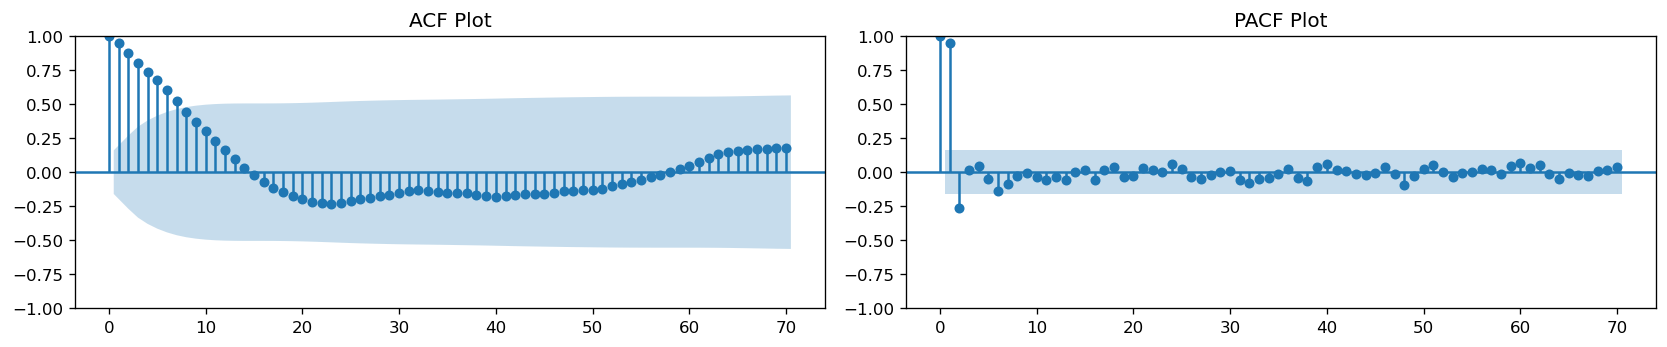

In [300]:
plt.figure(figsize=(14,3))

plt.subplot(121)
plot_acf(heart_rate.dropna(), lags=70, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(heart_rate.dropna(), lags=70, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

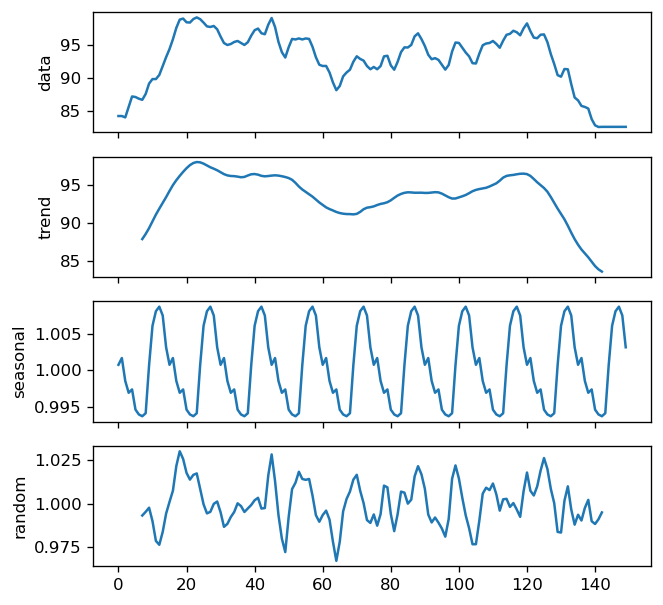

In [320]:
decomposed = decompose(heart_rate[0].values, "multiplicative", m=15)
decomposed_plot(decomposed, figure_kwargs={"figsize": (6, 6)}, show=False);

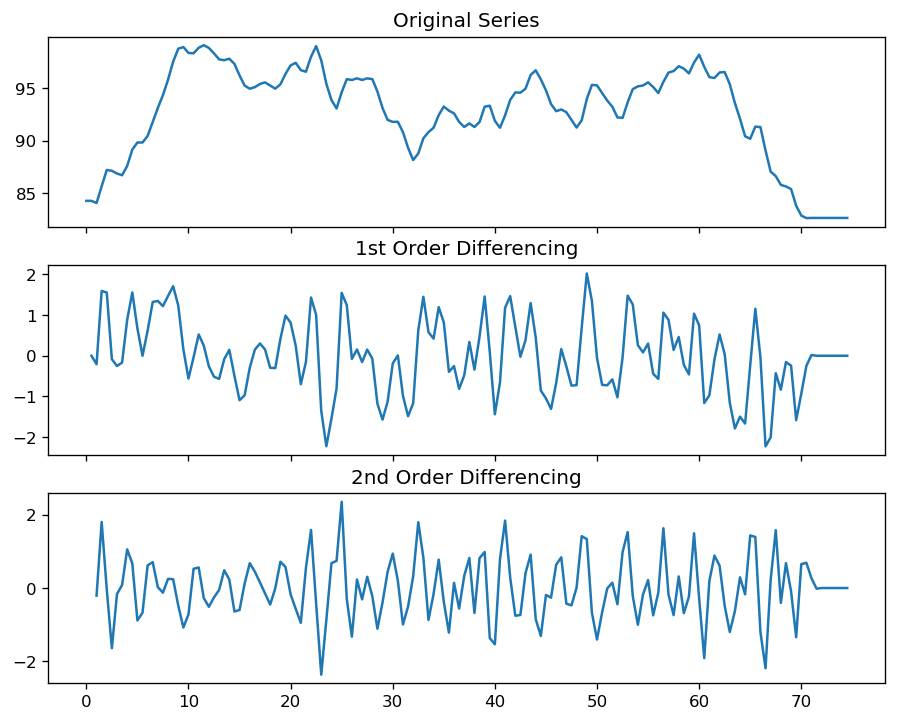

In [322]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(heart_rate); axes[0].set_title('Original Series')

axes[1].plot(heart_rate.diff()); axes[1].set_title('1st Order Differencing')

axes[2].plot(heart_rate.diff().diff()); axes[2].set_title('2nd Order Differencing')
plt.show()

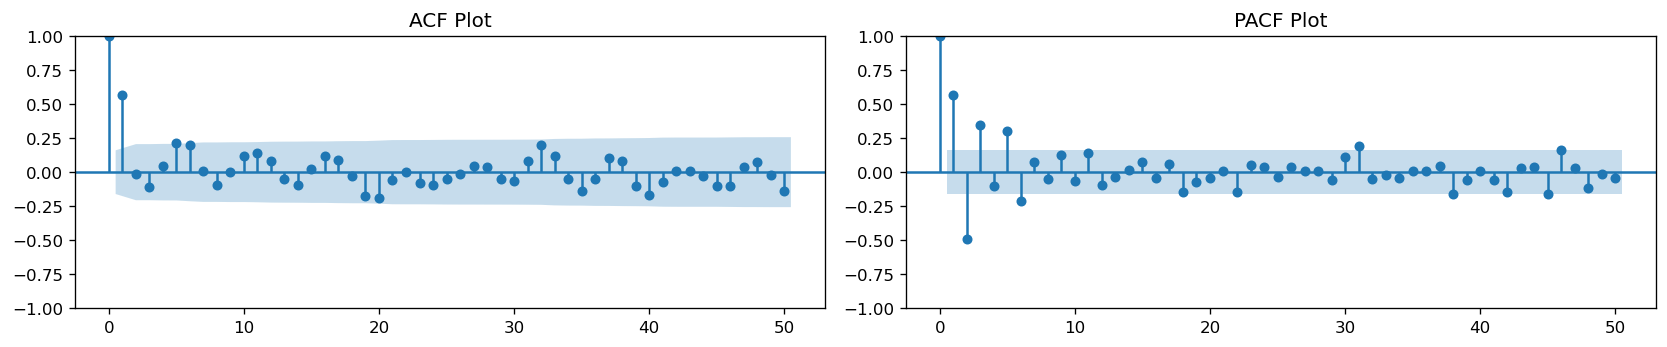

In [323]:
plt.figure(figsize=(14,3))

plt.subplot(121)
plot_acf(heart_rate.diff().dropna(), lags=50, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(heart_rate.diff().dropna(), lags=50, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

In [341]:
heart_rate[0].loc[:int(len(data)*0.2)]

0.0     84.2697
0.5     84.2697
1.0     84.0619
1.5     85.6542
2.0     87.2093
         ...   
28.0    95.8501
28.5    94.6703
29.0    93.0993
29.5    91.9720
30.0    91.7821
Name: 0, Length: 61, dtype: float64

/home/dmitrii.druzhbin@Digital-Grenoble.local/anaconda3/envs/keras_gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dmitrii.druzhbin@Digital-Grenoble.local/anaconda3/envs/keras_gpu/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dmitrii.druzhbin@Digital-Grenoble.local/anaconda3/envs/keras_gpu/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/dmitrii.druzhbin@Digital-Grenoble.local/anaconda3/envs/keras_gpu/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization fa

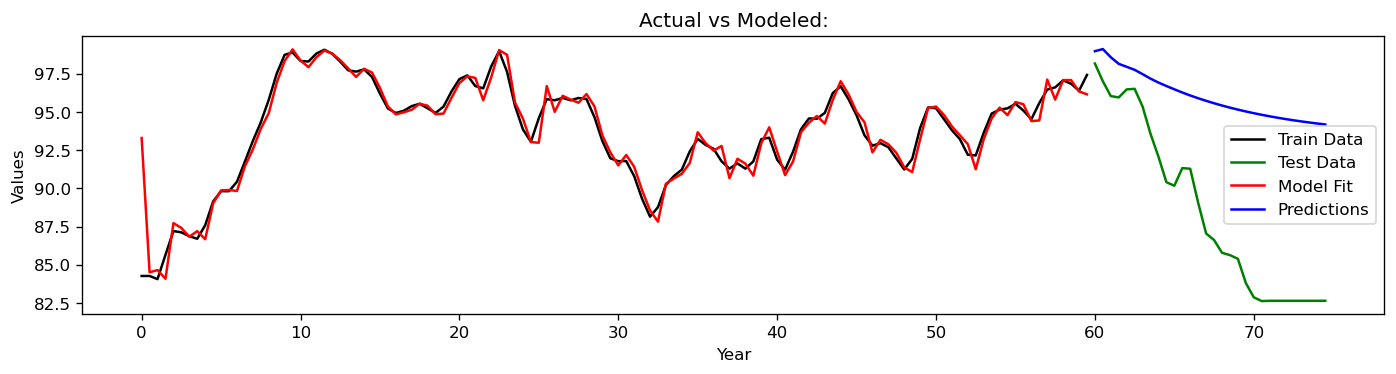

Mean Absolute Error (MAE): 7.556
Mean Squared Error (MSE): 73.495
Root Mean Squared Error (RMSE): 8.573
Mean Absolute Percentage Error (MAPE): nan%


In [361]:
model = ARIMA((5,0,1))

data = heart_rate[0]

train_size = int(len(data)*0.8)

train = data.iloc[:train_size]
test = data.iloc[train_size:]

model_fit = model.fit(train)

predictions = model.predict(n_periods=len(test))

plt.figure(figsize=(14, 3))
plt.plot(train.index, train, label='Train Data', color='black')
plt.plot(test.index, test, label='Test Data', color='green')
plt.plot(train.index, model_fit.fittedvalues(), label='Model Fit', color='red')
plt.plot(test.index, predictions, label='Predictions', color='blue')

plt.legend()
plt.title(f'Actual vs Modeled:')
plt.xlabel('Year')
plt.ylabel('Values')
plt.show()

mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - predictions) / test)) * 100

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")

In [368]:
lynx = pd.Series(get_ds(dataset_names[5]))
lynx.info()

<class 'pandas.core.series.Series'>
Index: 114 entries, 1821 to 1934
Series name: None
Non-Null Count  Dtype  
--------------  -----  
114 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB


In [369]:
START_DATE = "1821"
lynx.index = date_range(START_DATE, periods=len(lynx), freq="YS")

In [370]:
lynx.head()

1821-01-01     269.0
1822-01-01     321.0
1823-01-01     585.0
1824-01-01     871.0
1825-01-01    1475.0
Freq: YS-JAN, dtype: float64

In [378]:
def autoarima_with_plot_and_stats_2(data, data_name, test_size, seasonal_period=12):
    
    test_size = int(len(data)*test_size)
    
    train = data[:-test_size]
    test = data[-test_size:]
    
    model = auto_arima(train,
                       start_p=0,
                       start_q=0,
                       start_P=0,
                       start_Q=0,
                       seasonal=True, 
                       m=seasonal_period, 
                       trace=True, 
                       error_action='ignore',
                       stepwise=True,
                       suppress_warnings=True)
    
    model_fit = model.fit(train)
    
    predictions = model.predict(n_periods=test_size)
    
    plt.figure(figsize=(14, 3))
    plt.plot(train.index, train, label='Train Data', color='black')
    plt.plot(test.index, test, label='Test Data', color='green')
    plt.plot(train.index, model_fit.fittedvalues(), label='Model Fit', color='red')
    plt.plot(test.index, predictions, label='Predictions', color='blue')
    
    plt.legend()
    plt.title(f'Actual vs Modeled: {data_name}')
    plt.xlabel('Year')
    plt.ylabel('Values')
    plt.show()
    
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test - predictions) / test)) * 100
    
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")
    
    return model_fit

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=1625.985, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=1556.066, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=1544.260, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=1680.540, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[5] intercept   : AIC=1553.974, Time=0.13 sec
 ARIMA(0,0,1)(1,0,1)[5] intercept   : AIC=1528.157, Time=0.48 sec
 ARIMA(0,0,1)(1,0,0)[5] intercept   : AIC=1536.626, Time=0.24 sec
 ARIMA(0,0,1)(2,0,1)[5] intercept   : AIC=1528.723, Time=0.58 sec
 ARIMA(0,0,1)(1,0,2)[5] intercept   : AIC=1535.796, Time=0.74 sec
 ARIMA(0,0,1)(0,0,2)[5] intercept   : AIC=1533.059, Time=0.53 sec
 ARIMA(0,0,1)(2,0,0)[5] intercept   : AIC=1526.701, Time=0.44 sec
 ARIMA(0,0,0)(2,0,0)[5] intercept   : AIC=1591.330, Time=0.43 sec
 ARIMA(1,0,1)(2,0,0)[5] intercept   : AIC=1517.248, Time=0.41 sec
 ARIMA(1,0,1)(1,0,0)[5] intercept   : AIC=1526.122, Time=0.44 sec
 ARIMA(1,0,1)(2,0,1)[5] intercept

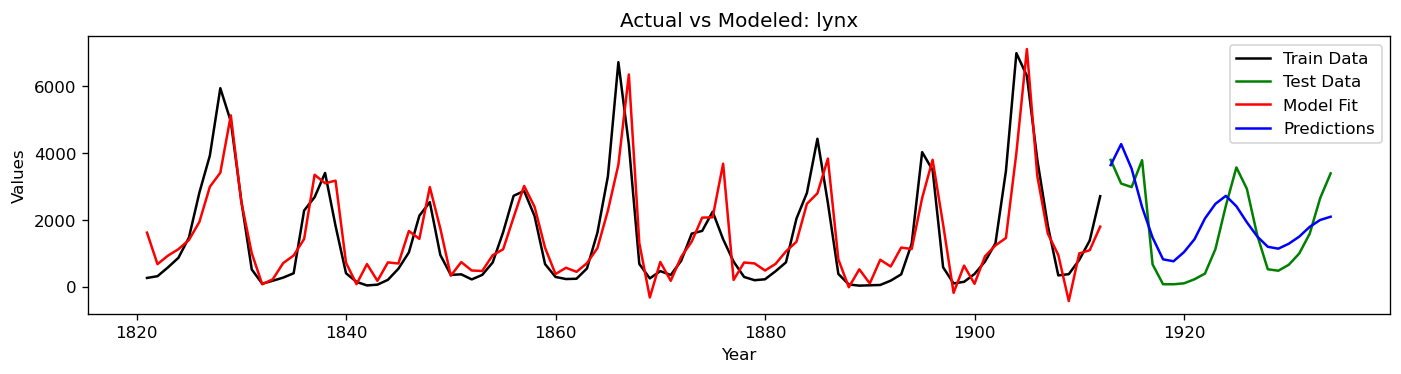

Mean Absolute Error (MAE): 807.430
Mean Squared Error (MSE): 833335.028
Root Mean Squared Error (RMSE): 912.872
Mean Absolute Percentage Error (MAPE): 203.636%


ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(2, 0, 0, 5),
      suppress_warnings=True)

In [382]:
autoarima_with_plot_and_stats_2(lynx,'lynx', 0.2, 5)

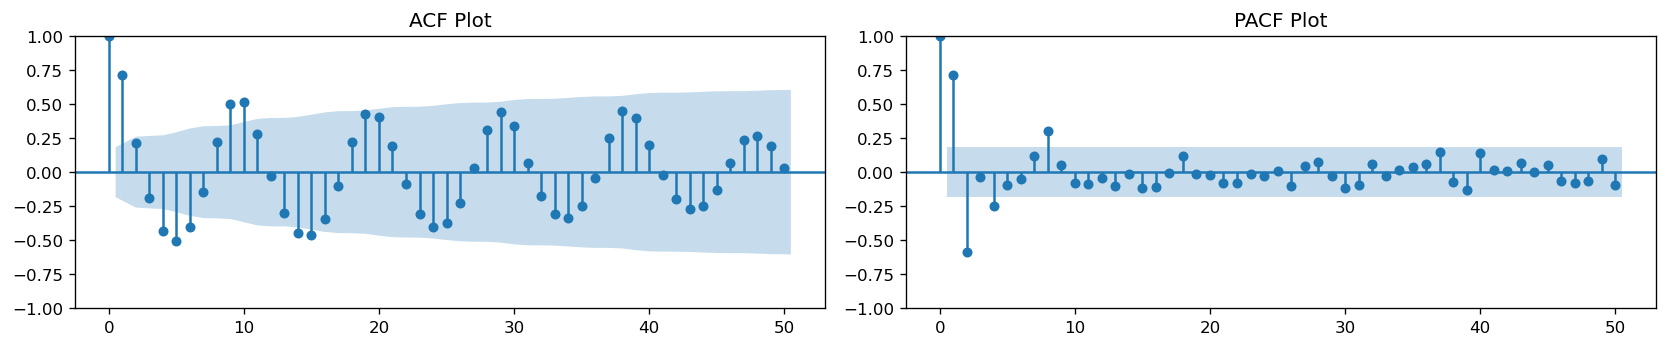

In [373]:
plt.figure(figsize=(14,3))

plt.subplot(121)
plot_acf(lynx.dropna(), lags=50, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(lynx.dropna(), lags=50, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

In [397]:
msft = pmdarima.datasets.load_msft()
msft.set_index('Date',inplace=True)
close = msft['Close']
close.head()
close.shape

(7983,)

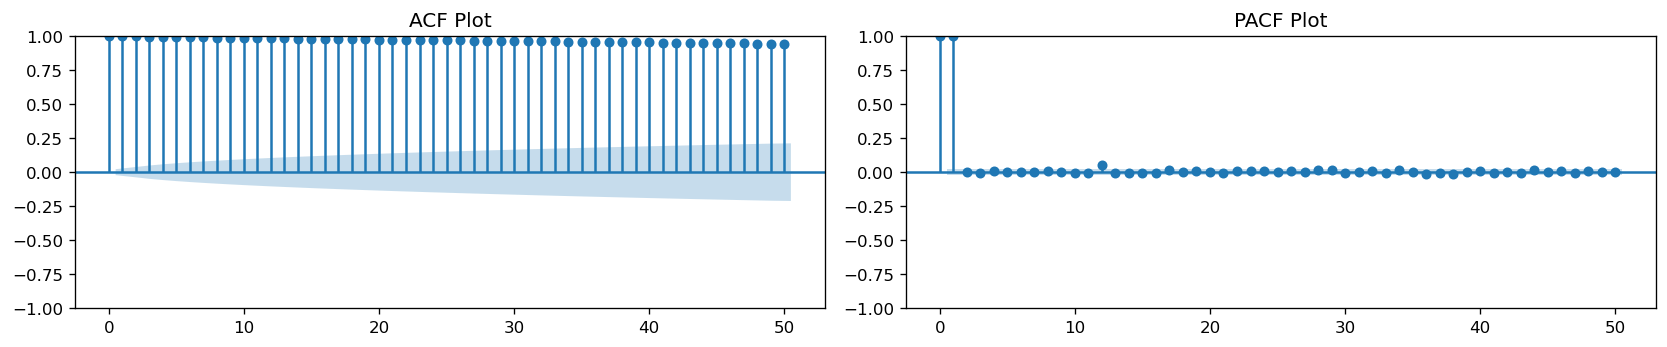

In [395]:
plt.figure(figsize=(14,3))

plt.subplot(121)
plot_acf(close.dropna(), lags=50, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(close.dropna(), lags=50, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

In [396]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(close); axes[0].set_title('Original Series')

axes[1].plot(close.diff()); axes[1].set_title('1st Order Differencing')

axes[2].plot(close.diff().diff()); axes[2].set_title('2nd Order Differencing')
plt.show()

KeyboardInterrupt: 

In [394]:
model = ARIMA((5,0,1))

data = heart_rate[0]

train_size = int(len(data)*0.8)

train = data.iloc[:train_size]
test = data.iloc[train_size:]

model_fit = model.fit(train)

predictions = model.predict(n_periods=len(test))

plt.figure(figsize=(14, 3))
plt.plot(train.index, train, label='Train Data', color='black')
plt.plot(test.index, test, label='Test Data', color='green')
plt.plot(train.index, model_fit.fittedvalues(), label='Model Fit', color='red')
plt.plot(test.index, predictions, label='Predictions', color='blue')

plt.legend()
plt.title(f'Actual vs Modeled:')
plt.xlabel('Year')
plt.ylabel('Values')
plt.show()

mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - predictions) / test)) * 100

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5930.080, Time=0.93 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5923.051, Time=3.39 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5922.905, Time=3.76 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5928.607, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=5925.955, Time=0.61 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5919.582, Time=10.50 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=5923.101, Time=3.36 sec


KeyboardInterrupt: 